# Making Maps with Cartopy

**Requirements:** The `conda/analysis3-20.10` (or later) module on the OOD or Gadi (or your own up-to-date cookbook installation).

This tutorial runs through a series of examples that demonstrate how to make maps using data from the COSIMA Cookbook. This tutorial focusses on mapping with `Cartopy`. 

Back in the day `Basemap` was the standard plotting library for plotting data on maps. However, `Basemap` is [deprecated](https://matplotlib.org/basemap/) in favour of `Cartopy`. Therefore, `Basemap` is no longer actively developed or supported and neither is included in CMS curated `conda` environments at NCI.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

save = '/home/561/mv7494/ENSOAnt_figures/'
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import gridspec
import matplotlib.path as mpath 
import matplotlib.patches as mpatch
import string # for subplot annotation
# from wrf import to_np # conversion to arrays required for arrows on maps 
import matplotlib.ticker as mticker # for ticks in cartopy (longitude/latitude)
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cosima_cookbook as cc
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### First, load in the unmasked coordinates 

In [2]:
%%time
var = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'] # get the unmasked coordinates for plotting later on
for f in range(4):
    ds = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc')[var[f]] # get the dataset structure
    ds.values = xr.open_mfdataset('/g/data/ik11/grids/ocean_grid_01.nc')[var[f]].values # feed in the unmasked data into the dataset structure
    if f == 0: geolon_t = ds
    if f == 1: geolat_t = ds
    if f == 2: geolon_c = ds
    if f == 3: geolat_c = ds # I need the xarray.DataArray 'geolon_t' (yt_ocean: 2700xt_ocean: 3600) structure for later on calculating the make_boundary_path() function

CPU times: user 2.79 s, sys: 3.02 s, total: 5.81 s
Wall time: 12.6 s


### Sector map

This map shows a sector of the Southern Ocean. It involves a Stereographic projection and a fairly complicated cutout to set the boundary of the map, but gives a nice result.

### create shelf mask for 1/10° model

In [3]:
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000

# now also for velocity cells
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_ucells = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000


### load in temperature and wind stress data from the idealised simulations

In [ ]:
%%time
base = ['/g/data/ik11/outputs/access-om2-01/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp = ['01deg_jra55v13_ryf9091','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file = ['ocean.nc', 'ocean_month.nc', 'ocean_month.nc']
# --------------------------------------------------------------------------------- #
time_step = [  11, 23]   # Achtung, started bei 0! [10, 13] = November - Januar   #
depth     = [  23,   47]   # [   23,   47] = 97.6 m - 1017 m                        #
sel_lat   = [  26,  529]   # [  26,  529]  = 80.01°S - 58.04°S                      #
sel_lon   = [1099, 3201]   # [1099, 3201]  = 170.05°W - 40.05°W                     #
# --------------------------------------------------------------------------------- #
nr_outputs =    8  # define number of output files to consider                      #
last_output = 983  # the last output to consider loading in                         #
# --------------------------------------------------------------------------------- #
for e in range(3):
    print(exp[e])    
    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = [] # empty list which I fill up
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'
        
    if e in [0, 1]:
        temp  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step[0], :, :, :] # select subset of data
    if e in [2]:
        temp  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step[1], :, :, :] # select subset of data
    tau_x = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).tau_x
    tau_y = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).tau_y

    if e == 0: temp_clim = temp; tau_x_clim = tau_x; tau_y_clim = tau_y; 
    if e == 1: 
        temp_EN_anom  = ((temp - temp_clim) * above1000_tcells)[depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('st_ocean').load() # calculate anomalies, select shelf < 1000 m, take Nov-Jan mean & load into MEM 
        temp_EN_anom_full_depth  = ((temp - temp_clim) * above1000_tcells).load() # calculate anomalies, select shelf < 1000 m, take Nov-Jan mean & load into MEM 
        tau_x_EN_anom = ((tau_x - tau_x_clim))[time_step[0]].load(); tau_y_EN_anom = ((tau_y - tau_y_clim))[time_step[0]].load()
    if e == 2:
        temp_LN_anom  = ((temp - temp_clim) * above1000_tcells)[depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('st_ocean').load() # same for La Niña but shifted one year
        temp_LN_anom_full_depth  = ((temp - temp_clim) * above1000_tcells).load() # calculate anomalies, select shelf < 1000 m, take Nov-Jan mean & load into MEM 
        tau_x_LN_anom = ((tau_x - tau_x_clim))[time_step[0]+12].load(); tau_y_LN_anom = ((tau_y - tau_y_clim))[time_step[0]+12].load()

# plt.figure(figsize=(27,4)); plt.subplot(1,2,1); (temp_EN_anom).plot(levels=np.linspace(-.5,.5,21)); plt.subplot(1,2,2); (temp_LN_anom).plot(levels=np.linspace(-.5,.5,21))
# Wall time: 3.4 s

01deg_jra55v13_ryf9091
01deg_jra55_ryf_ENFull


### Adding the depth/latitude plots now below the spatial patterns

In [ ]:
%%time
base   = ['/g/data/ik11/outputs/access-om2-01/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55v13_ryf9091','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea', 'West Antarctica']
# ---------------------------------------------------------------------------------- #
depth     = [   0,   47]  # [  0,    47] = 0.5 m - 1017 m                            #
sel_lat   = [   0,  800]  # [120,   263] = 76.03°S - 70.04°S                         #
sel_lonAS = [1529, 1790]  # [1529, 1790] = 127.1°W - 101.1°W                         #
sel_lonBS = [1790, 2000]  # [1790, 2000] = 101.1°W - 80.05°W                         #
lon_lonWA = [1299, 2200]  # 150°W - 60°W                                             #
# ---------------------------------------------------------------------------------- #
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    if e == 1: last_output = 983; nr_outputs = 8; time_step = 11 # for ENFull, I only have output976-output980
    if e == 2: last_output = 983; nr_outputs = 8; time_step = 23
        
    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] # string with all file locations
    temp_clim  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step,depth[0]:depth[1], sel_lat[0]:sel_lat[1], :] # open data sets
    temp  = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step, depth[0]:depth[1], sel_lat[0]:sel_lat[1], :]
    
    if e == 1: anom_EN = temp - temp_clim
    if e == 2: anom_LN = temp - temp_clim

for e in [1,2]: # loop through the two simulations, ENFull and LNFull
    print(exp[e])
    # del clim; del anom
    for r in [2]:#range(3): # loop through the three regions Amundsen Sea, Bellingshausen Sea and West Antarctica
        print(region[r])
        # if e == 1 and r == 0: anom = anom_EN[:,:,sel_lonAS[0]:sel_lonAS[1]].load(); clim = temp_clim[:,:,sel_lonAS[0]:sel_lonAS[1]].load()
        # if e == 1 and r == 1: anom = anom_EN[:,:,sel_lonBS[0]:sel_lonBS[1]].load(); clim = temp_clim[:,:,sel_lonBS[0]:sel_lonBS[1]].load()
        if e == 1 and r == 2: anom = anom_EN[:,:,lon_lonWA[0]:lon_lonWA[1]].load(); clim = temp_clim[:,:,lon_lonWA[0]:lon_lonWA[1]].load()
        # if e == 2 and r == 0: anom = anom_LN[:,:,sel_lonAS[0]:sel_lonAS[1]].load(); clim = temp_clim[:,:,sel_lonAS[0]:sel_lonAS[1]].load()
        # if e == 2 and r == 1: anom = anom_LN[:,:,sel_lonBS[0]:sel_lonBS[1]].load(); clim = temp_clim[:,:,sel_lonBS[0]:sel_lonBS[1]].load()
        if e == 2 and r == 2: anom = anom_LN[:,:,lon_lonWA[0]:lon_lonWA[1]].load(); clim = temp_clim[:,:,lon_lonWA[0]:lon_lonWA[1]].load() 

        # replace the different sections that have data south of the 1000 m isobath with nan (i.e., the regions that are deeper than 1000 m)
        for s in range(2): # loop through both the climatological and anomalous arrays
            if s == 0: array = clim
            if s == 1: array = anom 
            array[-1,0:160,90:]    = array[-1,    0:160,90:].where(array[-1,   0:160, 90:] < 5)
            array[-1,150:200,300:] = array[-1, 150:200,300:].where(array[-1, 150:200,300:] < 5)
            array[-1,180:290,728:] = array[-1, 180:290,728:].where(array[-1, 180:290,728:] < 5)
            array[-1,250:300,740:] = array[-1, 250:300,740:].where(array[-1, 250:300,740:] < 5)
            array[-1,300:390,830:] = array[-1, 300:390,830:].where(array[-1, 300:390,830:] < 5)
            array[-1,400:439,880:] = array[-1, 400:439,880:].where(array[-1, 400:439,880:] < 5)
            array[-1,:249,550:]    = array[-1,    :249,550:].where(array[-1,    :249,550:] < 5)
            # array[-1,:220,:]      = array[-1,   0:220,   :].where(array[-1,      0:220,:] < 5)
            # array[-1,:258,140:250]= array[-1,0:258,140:250].where(array[-1,0:258,140:250] < 5)
            if s == 0: clim = array - 273.15 # convert from K to °C
            if s == 1: anom = array
            
        if e == 1: anom_EN = anom
        if e == 2: anom_LN = anom

In [ ]:
%%time
plt.figure(figsize=(16,3))
plt.subplot(1,2,1); anom_EN[-1,:,:].plot()
plt.subplot(1,2,2); clim[-1,:,:].plot()
# Wall time: 170 ms

In [ ]:
%%time 
import scipy
Re = 6378000.0                   # radius of the Earth
lat_to_km = 2*np.pi*Re/360.0/1e3 # for converting latitudes to kilometer
len_of_rectangle = 40 # number of grid cells in each rectangle

def get_angle(data):
    a = np.linspace(0,len(data.xt_ocean), len(data.xt_ocean)+1)
        
    angle_array = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    dx_array    = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    dy_array    = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    
    lat_left_array    = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    lon_left_array    = np.full(int(len(data.xt_ocean)/len_of_rectangle), np.nan) # prepare empty array to fill up
    lat_right_array   = lat_left_array; lon_right_array = lon_left_array # ... and copy over the structure for the right-hand side arrays of the rectangle
    

    for f,g in zip(a[0::len_of_rectangle],a[len_of_rectangle::len_of_rectangle]): # loop through the pairs
        f = int(f); g = int(g)

        # get the left-most grid cell and evaluate the first grid cell with data, i.e. just after the shelf break
        left  = pd.Series(data[-1,:,f]).first_valid_index()
        lat_left = data[-1,:,f][left].yt_ocean.values # latitude of said grid cell
        lon_left = data[-1,:,f][left].xt_ocean.values # longitude

        # now same with the right-most grid cell in the 10-grid cell slice
        right = pd.Series(data[-1,:,g]).first_valid_index()
        lat_right = data[-1,:,g][right].yt_ocean.values
        lon_right = data[-1,:,g][right].xt_ocean.values    
        # print(str(f) + ' [' + str(left) + '] -> ' + str(g) + ' [' + str(right) + ']')

        # using trigonometry to get the angle of the shelf break between the first and last grid cell in a ten-grid-cell slice
        dy_array[int(f/len_of_rectangle)] = (lat_right - lat_left) * lat_to_km                                            # latitudinal distance [km]
        dx_array[int(f/len_of_rectangle)] = (lon_right - lon_left) * lat_to_km * np.cos(np.pi/180*(lat_right+lat_left)/2) # longitudinal distance [km]

        angle_array[int(f/len_of_rectangle)]    = (np.arctan(dy_array[int(f/len_of_rectangle)]/dx_array[int(f/len_of_rectangle)])) * 180/np.pi # calculate the angle and convert from rad to ° using (*180/np.pi)
        lat_left_array[int(f/len_of_rectangle)] = lat_left; lat_right_array[int(f/len_of_rectangle)] = lat_right
        lon_left_array[int(f/len_of_rectangle)] = lon_left; lon_right_array[int(f/len_of_rectangle)] = lon_right

    return angle_array, dx_array, dy_array, lat_left_array, lon_left_array, lat_right_array, lon_right_array       

[angle_array, dx_array, dy_array, lat_left_array, lon_left_array, lat_right_array, lon_right_array] = get_angle(clim)

### Get rectangle, rotate it

In [ ]:
%%time
def get_lon_lat_rotated(w, x, y, O, N, ang, delx, dely, res, data):
    "This function does this and this:"
    "The input is: w = 5*lat_to_km # width of rectangle [km]"
    "              x = -110         # x-center of the rectangle [°lon]"
    "              y = -72          # y-center of the rectangle [°lat]"
    "              O = 3*lat_to_km # offshore length [km]"
    "              N = 4*lat_to_km  # onshore length [km]"
    "              ang = 20 * (np.pi/180) # angle of coastline in (°rad)"
    "              delx = .5*lat_to_km  # delta_x [km]"
    "              dely = .35*lat_to_km # delta_y [km]"
    "              res = 10 # increase the resolution of the interpolated data by 10"
    "              data = the data used to do the interpolation"
   

    # # -------------------------------------------------- #
    # w = 0.01
    # x = lon_left_array[f] - (lon_left_array[f]-lon_left_array[f+1])/2
    # y = lat_left_array[f] + (lat_left_array[f]-lat_left_array[f+1])/2
    # O = 2
    # N = 2 
    # ang = angle_array[0] 
    # delx = dx_array[0] 
    # dely = dy_array[0] 
    # res = 10 
    # data = anom_EN
    # # -------------------------------------------------- #


    # conversions from the input from [°lat/°lon] to [km]
    w    = w * lat_to_km 
    O    = O * lat_to_km 
    N    = N * lat_to_km
    ang  = ang * (np.pi/180)
    delx = delx * lat_to_km
    dely = dely * lat_to_km

    x_r = np.linspace(-w,w,res)#*int(2*w/delx))   # x-axis of rotated section [km]
    y_r = np.linspace(-N,O,res)#*int((N+O)/dely)) # y-axis of rotated section [km]
    [X_r, Y_r] = np.meshgrid(x_r, y_r) # create meshgrid from the rotated coordinates [km]

    # create empty arrays which get filled in with the rotated values in 
    lat_rot = np.full((len(x_r), len(y_r)), np.nan) # [km]
    lon_rot = np.full((len(x_r), len(y_r)), np.nan) # [km]

    import math # package that has the atan2 (arctan2) function 
    for i in range(len(x_r)):                     # loop through each x-axis grid cell [km]
        for j in range(len(y_r)):                 # loop through each y-axis grid cell [km]
            phi = math.atan2(y_r[j],x_r[i]);      # angle from center point
            leng = np.sqrt(x_r[i]**2+y_r[j]**2);  # distance from center point

            # calculating the rotated longitude and latitude coordinates [°lat, °lon]
            # -------------------------------------------------------------------------------------------------------- #
            lat_rot[i,j] = y + np.sin(phi+ang)*leng/lat_to_km; # lat of point
            lon_rot[i,j] = x + np.cos(phi+ang)*leng/lat_to_km/np.cos(np.pi/180*(lat_rot[i,j]+y)/2);  # lon of point
            # -------------------------------------------------------------------------------------------------------- #

    interpolated_data = np.full((len(clim.st_ocean), len(x_r), len(y_r)), np.nan) # create empty array with same dimensions as lon_rot

    # the interpolation here
    for z in range(len(data.st_ocean)): # loop over all depth layers
        # create interpolation function         (old x-axis,    old y-axis,                 old data)
        function = scipy.interpolate.interp2d(data.xt_ocean, data.yt_ocean, data[z,:,:].fillna(1e6)) # fill all nan with 9999

        for i in range(len(x_r)): # loop through all the grid cells and interpolate the data onto the rotated grid
            for j in range(len(y_r)): 
                interpolated_data[z,i,j] = function(lon_rot[i,j], lat_rot[i,j])
        # if z % 20 == 0: print('up to st_ocean level '+ str(z) + ' done') # print out statement every 5-th z level to see progress through the loops
    interpolated_data[interpolated_data>2]=np.nan # to get the nan back, replace all data that is above 2°C with nan
                                                   # this is a valid assumption because ENSO-induced temperature anomalies are never bigger than that 
    # print('----------------------------')
    return interpolated_data, lon_rot, lat_rot, x, y, x_r, y_r # save the output variables I need
    # Wall time: 3min 13s

In [ ]:
%%time

# (  w,   x,   y, O, N, ang, delx, dely, res, data):
# [interpolated_data, lon_rot_WAP, lat_rot_WAP, x, y, x_r, y_r] = get_lon_lat_rotated(4.2, -72, -70, 2, 2, angle_array[0], dx_array[0], dy_array[0], 10, anom_EN)
plt.figure(figsize=(27,9))
interp      = np.full((47, 50, len(angle_array)), np.nan) # empty array full of NaNs which gets filled up
interp_mask = np.full((47, 50, len(angle_array)), np.nan) # same array structure for the mask as well

# create empty arrays to fill with the corner points (lat, lon of each corner) of the rectangles
x0_points_north = np.full((len(angle_array)), np.nan); xe_points_north = np.full((len(angle_array)), np.nan)
y0_points_north = np.full((len(angle_array)), np.nan); ye_points_north = np.full((len(angle_array)), np.nan)
x0_points_south = np.full((len(angle_array)), np.nan); xe_points_south = np.full((len(angle_array)), np.nan)
y0_points_south = np.full((len(angle_array)), np.nan); ye_points_south = np.full((len(angle_array)), np.nan)

for e in range(3): # loop through the three experiments
    print(exp[e])
    if e == 0: data = clim;    panel = 1
    if e == 1: data = anom_EN; panel = 3
    if e == 2: data = anom_LN; panel = 5
    
    plt.subplot(3,2,panel); (clim[-1,100:350,300:710]-273.15).plot(cmap = 'RdBu_r', vmin=-1,vmax=1) # plot the top down view of the shelf break 
    
    if e == 0: mask = data.where(np.logical_or(data.isnull(), xr==0), 1).fillna(0) # create an ocean-land mask where ocean grid cells have value 1 and land grid cells have value 0

    for f in range(9,15): # range(len(angle_array)-1): # range(49,71) = Amundsen Sea 101°W - 80°W with 10 grid cells 
                                                        # range(60,87) = Amundsen Sea 101°W - 80°W with  8 grid cells
                                                        # range(42,75) = 115°W - 90°W with  10 grid cells
                                                        # range(49,75) = 110.05°W - 90.05°W with  10 grid cells
        if np.round(lon_left_array[f],0) % 10 == 0:
            print('loop at ' + str(np.abs(int(np.round(lon_left_array[f],0)))) + '°W')
            
        # using the function from above to interpolate the data onto an across-shelf grid
        [interpolated_data, lon_rot_ABS, lat_rot_ABS, x_ABS, y_ABS, x_r_ABS, y_r_ABS] = get_lon_lat_rotated(.65, # width of rectangle
                                                                                                            lon_left_array[f] + (lon_right_array[f]-lon_left_array[f])/2, # x-coordinate of rectangle center
                                                                                                            lat_left_array[f] + (lat_right_array[f]-lat_left_array[f])/2, # y-coordinate of rectangle center
                                                                                                            2,                # off-shore length
                                                                                                            5,                # on-shore length
                                                                                                            angle_array[f],   # angle of rectangle
                                                                                                            dx_array[f],      # length, i.e., lon. distance of rectangle
                                                                                                            dy_array[f],      # height, i.e., lat. distance of rectangle
                                                                                                            50,               # resolution of interpolation 
                                                                                                            data)             # data to interpolate
        if e == 0:
            # same interpolation for the mask
            [interpolated_mask, lon_rot_ABS, lat_rot_ABS, x_ABS, y_ABS, x_r_ABS, y_r_ABS] = get_lon_lat_rotated(.65,
                                                      lon_left_array[f] + (lon_right_array[f]-lon_left_array[f])/2, 
                                                      lat_left_array[f] + (lat_right_array[f]-lat_left_array[f])/2, 2, 5, angle_array[f], dx_array[f], dy_array[f], 50, mask)

        # plot the rectangles along the shelf break on the left
        plt.plot(x_ABS,y_ABS, marker = 'o', c = 'white', markersize=10); plt.title('.nc data'); plt.plot(x_ABS,y_ABS, marker = 'o', c = 'orange', markersize=7); plt.title('.nc data')
        plt.scatter(lon_rot_ABS.reshape(-1), lat_rot_ABS.reshape(-1), marker = '.', s=5e-2)                                # 4.2, -70, -69, 2, 2, 76, .5, .5, 10      
        check_ABS = interpolated_data # save the data to check if all good in jupyter notebook cell below

        interp[:,:,f]      = np.nanmean(interpolated_data, axis=1) # take the mean over the longitude in each slice
        
        x0_points_north[f] = np.min(lon_rot_ABS[ 0]); xe_points_north[f] = np.min(lon_rot_ABS[-1]); y0_points_north[f] = np.max(lat_rot_ABS[ 0]); ye_points_north[f] = np.max(lat_rot_ABS[-1])
        x0_points_south[f] = np.max(lon_rot_ABS[ 0]); xe_points_south[f] = np.max(lon_rot_ABS[-1]); y0_points_south[f] = np.min(lat_rot_ABS[ 0]); ye_points_south[f] = np.min(lat_rot_ABS[-1])     
        
        
        plt.plot([np.min(lon_rot_ABS[ 0]), np.min(lon_rot_ABS[-1])], [np.max(lat_rot_ABS[0]), np.max(lat_rot_ABS[-1])], linewidth=.5, color = 'orange') # northern line
        plt.plot([np.max(lon_rot_ABS[ 0]), np.max(lon_rot_ABS[-1])], [np.min(lat_rot_ABS[0]), np.min(lat_rot_ABS[-1])], linewidth=.5, color = 'orange') # southern line
        plt.plot([np.min(lon_rot_ABS[ 0]), np.max(lon_rot_ABS[ 0])], [np.max(lat_rot_ABS[0]), np.min(lat_rot_ABS[ 0])], linewidth=.5, color = 'orange') # western line
        plt.plot([np.min(lon_rot_ABS[-1]), np.max(lon_rot_ABS[-1])], [np.max(lat_rot_ABS[-1]),np.min(lat_rot_ABS[-1])], linewidth=.5, color = 'orange') # eastern line    
        
        window = 3
        a_ABS = np.array([[i, j] for i, j in zip(x0_points_north, xe_points_north)]).ravel()
        b_ABS = np.array([[i, j] for i, j in zip(y0_points_north, ye_points_north)]).ravel()
        c_ABS = np.array([[i, j] for i, j in zip(x0_points_south, xe_points_south)]).ravel()
        d_ABS = np.array([[i, j] for i, j in zip(y0_points_south, ye_points_south)]).ravel()
        
        plt.plot(a_ABS, b_ABS, c='g', linestyle='--'); plt.plot(c_ABS, d_ABS, c='g', linestyle='--')
        for sl in range(len(a_ABS)):
            plt.plot([a_ABS[sl],c_ABS[sl]],[b_ABS[sl],d_ABS[sl]], color = rotblau[20], linewidth=2) # western line


        if e == 0: 
            interp_mask[:,:,f] = np.nansum(interpolated_mask, axis=1)

    # plot the interpolated data across the shelf on the right
    plt.subplot(3,2,panel+1); ax1 = plt.pcolormesh(y_r_ABS, clim.st_ocean, np.nanmean(interp, axis=2), cmap='RdBu_r', vmin=-.5, vmax=.5)
    plt.axvline(0, c = 'orange', linewidth=.5); plt.title(exp[e] + ' shelf temp anoms (°C)'); plt.colorbar(ax1)

    # save data for plotting later on
    if e == 0: interpolated_data_clim_ABS = np.nanmean(interp, axis=2); interpolated_mask_ABS = np.nanmean(interp_mask, axis=2) / len_of_rectangle # get the mean over each longitude slice 
    if e == 1: interpolated_data_EN_ABS   = np.nanmean(interp, axis=2)                                                                             # and divide by the rectangle width
    if e == 2: interpolated_data_LN_ABS   = np.nanmean(interp, axis=2)
    
    plt.contour(y_r_ABS, clim.st_ocean, interpolated_mask_ABS, levels = [.9], colors = ['k'], linewidths=5); 
    plt.contour(y_r_ABS, clim.st_ocean, interpolated_mask_ABS, levels = [.2], colors = ['g'], linewidths=5); 
    plt.gca().invert_yaxis()

    print('----------------------')
    
interpolated_mask_ABS[interpolated_mask_ABS < 0.2] = np.nan # replace all values in the mask smaller than 0.2 with np.nan
interpolated_mask_ABS[interpolated_mask_ABS >   1] = 1 # and replace all larger than 1 with 1...some mask values are slightly larger because of the interpolation

# multiply with mask to remove all data values that have smaller than 20* data in the ocean
interpolated_data_clim_ABS = interpolated_data_clim_ABS * interpolated_mask_ABS  
interpolated_data_EN_ABS   = interpolated_data_EN_ABS   * interpolated_mask_ABS  
interpolated_data_LN_ABS   = interpolated_data_LN_ABS   * interpolated_mask_ABS  

# Wall time: 1min 1s for the Amundsen Sea sector
# Wall time: 4min 36s for the Amundsen Sea sector with clim, anom_EN and anomLN

Second check to see if mask has correctly removed the data less than 20%

In [ ]:
ax1 = plt.pcolormesh(y_r_ABS, clim.st_ocean, interpolated_data_LN_ABS, cmap='RdBu_r', vmin=-.5, vmax=.5)
plt.axvline(0, c = 'orange', linewidth=.5); plt.colorbar(ax1)
plt.contour(y_r_ABS, clim.st_ocean, interpolated_mask_ABS, levels = [.9], colors = ['g'], linewidths=5); plt.gca().invert_yaxis()

### Now the same for the West Antarctic peninsula region

In [ ]:
%%time

# (  w,   x,   y, O, N, ang, delx, dely, res, data):
# [interpolated_data, lon_rot_WAP, lat_rot_WAP, x, y, x_r, y_r] = get_lon_lat_rotated(4.2, -72, -70, 2, 2, angle_array[0], dx_array[0], dy_array[0], 10, anom_EN)
plt.figure(figsize=(27,9))
interp      = np.full((47, 50, len(angle_array)), np.nan) # empty array full of NaNs which gets filled up
interp_mask = np.full((47, 50, len(angle_array)), np.nan) # same array structure for the mask as well

# create empty arrays to fill with the corner points (lat, lon of each corner) of the rectangles
x0_points_north = np.full((len(angle_array)), np.nan); xe_points_north = np.full((len(angle_array)), np.nan)
y0_points_north = np.full((len(angle_array)), np.nan); ye_points_north = np.full((len(angle_array)), np.nan)
x0_points_south = np.full((len(angle_array)), np.nan); xe_points_south = np.full((len(angle_array)), np.nan)
y0_points_south = np.full((len(angle_array)), np.nan); ye_points_south = np.full((len(angle_array)), np.nan)

for e in range(3): # loop through the three experiments
    print(exp[e])
    if e == 0: data = clim;    panel = 1
    if e == 1: data = anom_EN; panel = 3
    if e == 2: data = anom_LN; panel = 5
    
    plt.subplot(3,2,panel); (clim[-1,200:,680:]-273.15).plot(cmap = 'RdBu_r', vmin=-1,vmax=1) # plot the top down view of the shelf break 
    
    if e == 0: mask = data.where(np.logical_or(data.isnull(), xr==0), 1).fillna(0) # create an ocean-land mask where ocean grid cells have value 1 and land grid cells have value 0


    for f in range(17,21): # range(len(angle_array)-1): # range(49,71) = Amundsen Sea 101°W - 80°W with 10 grid cells 
                                                        # range(60,87) = Amundsen Sea 101°W - 80°W with  8 grid cells
                                                        # range(42,75) = 115°W - 90°W with  10 grid cells
                                                        # range(49,75) = 110.05°W - 90.05°W with  10 grid cells
        if np.round(lon_left_array[f],0) % 10 == 0:
            print('loop at ' + str(np.abs(int(np.round(lon_left_array[f],0)))) + '°W')
            
        # using the function from above to interpolate the data onto an across-shelf grid
        [interpolated_data, lon_rot_WAP, lat_rot_WAP, x_WAP, y_WAP, x_r_WAP, y_r_WAP] = get_lon_lat_rotated(.65, # width of rectangle
                                                                                                            lon_left_array[f] + (lon_right_array[f]-lon_left_array[f])/2, # x-coordinate of rectangle center
                                                                                                            lat_left_array[f] + (lat_right_array[f]-lat_left_array[f])/2, # y-coordinate of rectangle center
                                                                                                            2,                # off-shore length
                                                                                                            5,                # on-shore length
                                                                                                            angle_array[f],   # angle of rectangle
                                                                                                            dx_array[f],      # length, i.e., lon. distance of rectangle
                                                                                                            dy_array[f],      # height, i.e., lat. distance of rectangle
                                                                                                            50,               # resolution of interpolation 
                                                                                                            data)             # data to interpolate
        if e == 0:
            # same interpolation for the mask
            [interpolated_mask, lon_rot_WAP, lat_rot_WAP, x_WAP, y_WAP, x_r_WAP, y_r_WAP] = get_lon_lat_rotated(.65,
                                                      lon_left_array[f] + (lon_right_array[f]-lon_left_array[f])/2, 
                                                      lat_left_array[f] + (lat_right_array[f]-lat_left_array[f])/2, 2, 5, angle_array[f], dx_array[f], dy_array[f], 50, mask)

        # plot the rectangles along the shelf break on the left
        plt.plot(x_WAP,y_WAP, marker = 'o', c = 'white', markersize=10); plt.title('.nc data'); plt.plot(x_WAP,y_WAP, marker = 'o', c = 'orange', markersize=7); plt.title('.nc data')
        plt.scatter(lon_rot_WAP.reshape(-1), lat_rot_WAP.reshape(-1), marker = '.', s=5e-2)                                # 4.2, -70, -69, 2, 2, 76, .5, .5, 10      
        check_WAP = interpolated_data # save the data to check if all good in jupyter notebook cell below

        interp[:,:,f]      = np.nanmean(interpolated_data, axis=1) # take the mean over the longitude in each slice
        
        x0_points_north[f] = np.min(lon_rot_WAP[ 0]); xe_points_north[f] = np.min(lon_rot_WAP[-1]); y0_points_north[f] = np.max(lat_rot_WAP[ 0]); ye_points_north[f] = np.max(lat_rot_WAP[-1])
        x0_points_south[f] = np.max(lon_rot_WAP[ 0]); xe_points_south[f] = np.max(lon_rot_WAP[-1]); y0_points_south[f] = np.min(lat_rot_WAP[ 0]); ye_points_south[f] = np.min(lat_rot_WAP[-1]) 
        
        a_WAP = np.array([[i, j] for i, j in zip(x0_points_north, xe_points_north)]).ravel()
        b_WAP = np.array([[i, j] for i, j in zip(y0_points_north, ye_points_north)]).ravel()
        c_WAP = np.array([[i, j] for i, j in zip(x0_points_south, xe_points_south)]).ravel()
        d_WAP = np.array([[i, j] for i, j in zip(y0_points_south, ye_points_south)]).ravel()
        
                
        
        plt.plot(a_WAP, b_WAP, c='g', linestyle='--'); plt.plot(c_WAP, d_WAP, c='g', linestyle='--')
        
        if e == 0: 
            interp_mask[:,:,f] = np.nansum(interpolated_mask, axis=1)

    # plot the interpolated data across the shelf on the right
    plt.subplot(3,2,panel+1); ax1 = plt.pcolormesh(y_r_WAP, clim.st_ocean, np.nanmean(interp, axis=2), cmap='RdBu_r', vmin=-.5, vmax=.5)
    plt.axvline(0, c = 'orange', linewidth=.5); plt.title(exp[e] + ' shelf temp anoms (°C)'); plt.colorbar(ax1)

    # save data for plotting later on
    if e == 0: interpolated_data_clim_WAP = np.nanmean(interp, axis=2); interpolated_mask_WAP = np.nanmean(interp_mask, axis=2) / len_of_rectangle # get the mean over each longitude slice 
    if e == 1: interpolated_data_EN_WAP   = np.nanmean(interp, axis=2)                                                                             # and divide by the rectangle width
    if e == 2: interpolated_data_LN_WAP   = np.nanmean(interp, axis=2)
    
    plt.contour(y_r_WAP, clim.st_ocean, interpolated_mask_WAP, levels = [.9], colors = ['k'], linewidths=5); 
    plt.contour(y_r_WAP, clim.st_ocean, interpolated_mask_WAP, levels = [.2], colors = ['g'], linewidths=5); 
    plt.gca().invert_yaxis()

    print('----------------------')
    
interpolated_mask_WAP[interpolated_mask_WAP < 0.2] = np.nan # replace all values in the mask smaller than 0.2 with np.nan
interpolated_mask_WAP[interpolated_mask_WAP >=  1] = 1 # and replace all larger than 1 with 1...some mask values are slightly larger because of the interpolation

# multiply with mask to remove all data values that have smaller than 20* data in the ocean
interpolated_data_clim_WAP = interpolated_data_clim_WAP * interpolated_mask_WAP
interpolated_data_EN_WAP   = interpolated_data_EN_WAP   * interpolated_mask_WAP
interpolated_data_LN_WAP   = interpolated_data_LN_WAP   * interpolated_mask_WAP

# Wall time: 1min 1s for the Amundsen Sea sector
# Wall time: 4min 36s for the Amundsen Sea sector with clim, anom_EN and anomLN

In [ ]:
plt.subplot(2,2,1); 
plt.pcolormesh(y_r_ABS, clim.st_ocean, interpolated_data_EN_ABS, cmap='RdBu_r', vmin=-.5, vmax=.5)
plt.contour(y_r_ABS, clim.st_ocean, interpolated_mask_ABS, levels = [.9], colors = ['k'], linewidths=5); plt.gca().invert_yaxis()
plt.subplot(2,2,2); 
plt.pcolormesh(y_r_ABS, clim.st_ocean, interpolated_data_LN_ABS, cmap='RdBu_r', vmin=-.5, vmax=.5)
plt.contour(y_r_ABS, clim.st_ocean, interpolated_mask_ABS, levels = [.9], colors = ['k'], linewidths=5); plt.gca().invert_yaxis()

plt.subplot(2,2,3); 
plt.pcolormesh(y_r_WAP, clim.st_ocean, interpolated_data_EN_WAP, cmap='RdBu_r', vmin=-.5, vmax=.5)
plt.contour(y_r_WAP, clim.st_ocean, interpolated_mask_WAP, levels = [.9], colors = ['k'], linewidths=5); plt.gca().invert_yaxis()
plt.subplot(2,2,4); 
plt.pcolormesh(y_r_WAP, clim.st_ocean, interpolated_data_LN_WAP, cmap='RdBu_r', vmin=-.5, vmax=.5); 
plt.contour(y_r_WAP, clim.st_ocean, interpolated_mask_WAP, levels = [.9], colors = ['k'], linewidths=5); plt.gca().invert_yaxis()

In [ ]:
%%time
# ------------------------------------------------------------ #
zlev = -1 # for which z level to do the quick check?           #
data = anom_LN # anom_EN
# ------------------------------------------------------------ #

plt.figure(figsize=(27,8))
plt.subplot(2,3,1)
data[-1,:,:].plot(cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.scatter(lon_rot_ABS.reshape(-1), lat_rot_ABS.reshape(-1), marker = '.', s=1, c='red')
plt.plot(x_ABS,y_ABS, marker = 'o', c = 'white', markersize=10); plt.title('clim .nc data'); plt.plot(x_ABS,y_ABS, marker = 'o', c = 'k', markersize=7)
plt.subplot(2,3,2)
plt.pcolormesh(lon_rot_ABS, lat_rot_ABS, check_ABS[zlev,:,:], cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.plot(x_ABS,y_ABS, marker = 'o', c = 'white', markersize=10); plt.title('the small rectangle'); plt.plot(x_ABS,y_ABS, marker = 'o', c = 'k', markersize=7)
plt.subplot(2,3,3)
plt.pcolormesh(x_r_ABS, y_r_ABS, check_ABS[zlev,:,:].T, cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.plot(0, 0, marker = 'o', c = 'white', markersize=10); plt.title('the interpolated rectangle'); plt.plot(0, 0, marker = 'o', c = 'k', markersize=7)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- #
plt.subplot(2,3,4)
data[-1,:,:].plot(cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.scatter(lon_rot_WAP.reshape(-1), lat_rot_WAP.reshape(-1), marker = '.', s=1, c='red')
plt.plot(x_WAP,y_WAP, marker = 'o', c = 'white', markersize=10); plt.title('clim .nc data'); plt.plot(x_WAP,y_WAP, marker = 'o', c = 'k', markersize=7)
plt.subplot(2,3,5)
plt.pcolormesh(lon_rot_WAP, lat_rot_WAP, check_WAP[zlev,:,:], cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.plot(x_WAP,y_WAP, marker = 'o', c = 'white', markersize=10); plt.title('the small rectangle'); plt.plot(x_WAP,y_WAP, marker = 'o', c = 'k', markersize=7)
plt.subplot(2,3,6)
plt.pcolormesh(x_r_WAP, y_r_WAP, check_WAP[zlev,:,:].T, cmap = 'RdBu_r', vmin = -.1, vmax = .1)
plt.plot(0, 0, marker = 'o', c = 'white', markersize=10); plt.title('the interpolated rectangle'); plt.plot(0, 0, marker = 'o', c = 'k', markersize=7)

### Load in sea level pressure contours during the peak event

In [ ]:
for f in range(2):
    if f == 0: suffix = 'EN'
    if f == 1: suffix = 'LN'
    slp         = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/' + 'sp_mean_anoms_'+suffix+'.nc').psl
    ts = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/time_series/' + 'ts_mean_anoms_'+suffix+'.nc').psl

    if f == 0: slp_at_peak_EN = slp * ts.max().values # get the maximum amplitude during the El Ni\~no simulation
    if f == 1: slp_at_peak_LN = slp * ts.min().values # get the minimum amplitude during the La Ni\~na simulation

plt.figure(figsize=(16,4))
plt.subplot(1,2,1); (slp_at_peak_EN   ).plot(); plt.title('Peak EN SLP anoms (Pa)')
plt.subplot(1,2,2); (slp_at_peak_LN*-1).plot(); plt.title('Peak LN SLP anoms (Pa)') # I have to multiply LN anoms with -1 because negative SLP anoms * negative time series == positive

### Define functions for plotting

In [ ]:
%%time
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
import string # for subplot annotation  

# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 30), # longitude grid lines
                  ylocs= np.linspace(0, -90, num=10)) # latitude grid lines
    ax.coastlines(); # add coast lines
    # theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    # circle = mpath.Path(verts * radius + center)
    # ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
    # xlab =    [ 3.2,    2.4,    1.1,    .12,     -.4,     .3,    .85] # x-position of labels
    xlab =    [    1,    -.03,   -.03,    .12,    .23,     .3,      .66]#,     .41] # x-position of labels
    ylab =    [  .72,      .7,    .52,    .21,   -.04,    1.02,    1.02]#,     .05] # y-position of labels
    txt_lab = ['60°W', '150°W', '60°S', '70°S', '78°S', '120°W', '90°W']#, '150°W'] # label text
    # loop through the 7 label and surround with white space for higher visibility
    if f == 0:
        for l in range(len(xlab)):
            ax.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                    fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])      
def fancy_plot2(ax, titel):
    plt.title(titel, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    
    # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
    # labels = [item.get_text() for item in ax1.get_xticklabels()]
    # labels =       ['440', '330', '220', '110', '0', '0', '55', '110']
    # ax1.set_xticklabels(labels)   
def fancy_plot3(ax):
        ax.axhline(0, linewidth=.5, c='grey') # horizontal line at 0
        
        plt.title(titel, fontsize=16)
        plt.xlim([-150,-60]);# plt.ylim([-.1,.1])
        ax.tick_params(axis='y', labelcolor='k')
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        ax.set_ylabel('(Sv $^{\circ}$longitude$^{-1}$)', color='k', fontsize=16); ax1.set(xlabel=None) # hide x-axis label
        
        ax.set_xticks([-150, -120, -90, -60]) # custom x ticks
        labels = [item.get_text() for item in ax1.get_xticklabels()] # rewrite the labels to °W/°E
        labels =       ['150°W', '120°W', '90°W', '60°W']
        ax.set_xticklabels(labels)    

### Plotting routine

CPU times: user 31.4 s, sys: 1.04 s, total: 32.4 s
Wall time: 32.8 s


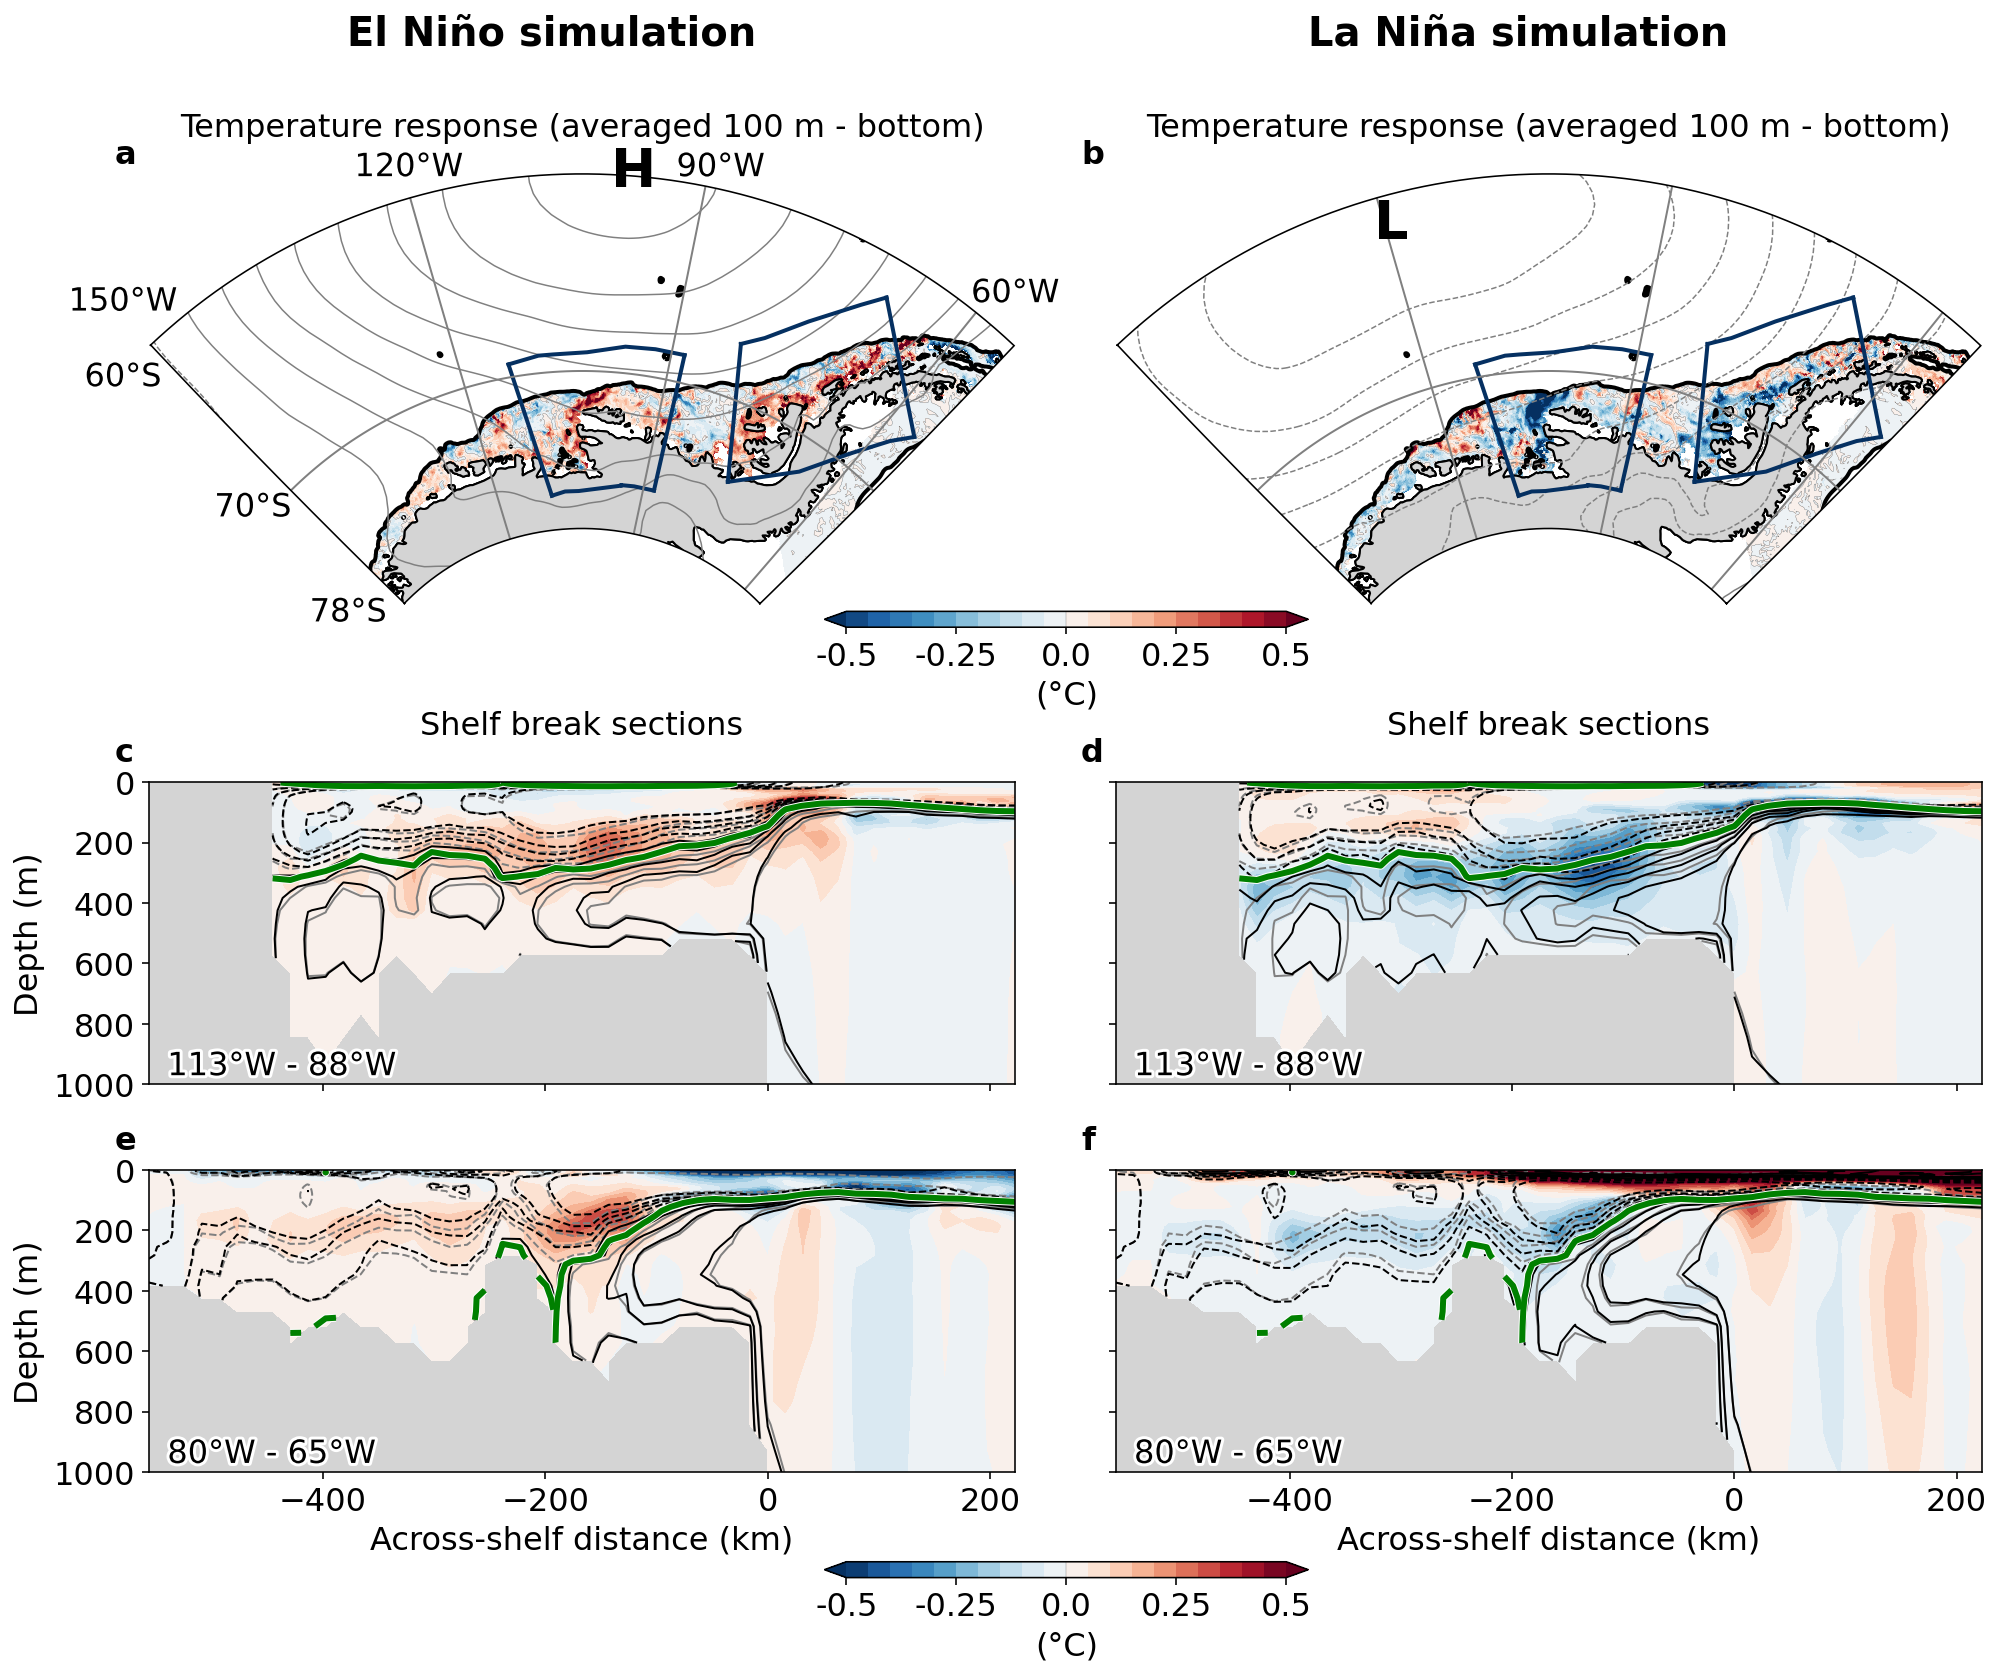

In [16]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(14, 11),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3,4, width_ratios = [1,.3,.3,1], height_ratios = [1,.5,.5]) 

midlon = -102.5
maxlon = midlon + 47.5
minlon = midlon - 47.5
minlat = -78
maxlat = -60
midlat = (minlat + maxlat)/2
ticks = np.linspace(-.5,.5,21)
month = 2 # only select timestep 3 of the dataset = 2045-12-16 12:00:00
for f in range(6):#range(7): # loop through each subplot
    if f == 0:  panel = gs[0,0:2]; map = temp_EN_anom; titel = 'Temperature response (averaged 100 m - bottom)\n'; pressure = slp_at_peak_EN
    if f == 1:  panel = gs[0,2:4]; map = temp_LN_anom; titel = 'Temperature response (averaged 100 m - bottom)\n'; pressure = slp_at_peak_LN*-1
                                                                                                                # isotherm positions during the event
    if f == 2:  panel = gs[1,0:2]; data = interpolated_data_EN_ABS; titel = 'Shelf break sections\n'; titel2 = '113°W - 88°W'; iso = interpolated_data_clim_ABS; y_r = y_r_ABS; interpolated_mask = interpolated_mask_ABS
    if f == 3:  panel = gs[1,2:4]; data = interpolated_data_LN_ABS; titel = 'Shelf break sections\n'; titel2 = '113°W - 88°W'; iso = interpolated_data_clim_ABS; y_r = y_r_ABS; interpolated_mask = interpolated_mask_ABS
                                                                                                                                       
    if f == 4:  panel = gs[2,0:2]; data = interpolated_data_EN_WAP; titel = ''; titel2 = '80°W - 65°W'; iso = interpolated_data_clim_WAP; y_r = y_r_WAP; interpolated_mask = interpolated_mask_WAP
    if f == 5:  panel = gs[2,2:4]; data = interpolated_data_LN_WAP; titel = ''; titel2 = '80°W - 65°W'; iso = interpolated_data_clim_WAP; y_r = y_r_WAP; interpolated_mask = interpolated_mask_WAP

    if f == 6:  panel = gs[1:3,1:3]; #data = across_shelf_Ekman_EN; titel = 'Poleward Ekman transport'; farbe = rotblau[ 3]
    # if f == 7:  panel = gs[3,2:4]; data = across_shelf_Ekman_LN; titel = 'Across-shelf Ekman transport'; farbe = rotblau[17]
    
    # panels with spatial maps -------------------------------------------------------------------------------------------------------------------- #
    if f in [0,1]:
        ax1 = plt.subplot(panel, projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
        ax1.coastlines(resolution='50m')

        lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
        lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

        ax1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

        boundary_path = make_boundary_path(lons, lats)
        ax1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1   = map.plot.pcolormesh(add_colorbar=False, levels=ticks, cmap='RdBu_r', transform=ccrs.PlateCarree())
        p11  = map.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())
        # 1000 dbar isobath
        p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        fancy_plot(ax1); # plt.suptitle('Shelf temperatures and surface wind stress', fontsize=16)          
        p2727 = (pressure/100).plot.contour(levels = np.linspace(-10,10,21), linewidths=.75, colors = 'grey', transform=ccrs.PlateCarree()) # sea level pressure contours
        
        if f == 0: plt.text(-105,-53,'El Niño simulation', fontsize=20, ha='center', va='center', fontweight='bold', transform=ccrs.PlateCarree()) # x0, y0
        if f == 1: plt.text(-105,-53,'La Niña simulation', fontsize=20, ha='center', va='center', fontweight='bold', transform=ccrs.PlateCarree()) # x0, y0


        # plot markers of maximum anomaly amplitude
        # max lon EN,   max lat EN, max lon LN,   max lat LN
        peak_anom_coords = [   262.6875, -59.81267266,     240.75, -61.49753151] # unfortunately I have to hardcode those as the loop goes over EN & LN and I want two markers
        if f == 0: 
            # peak_anom_coords = slp_anom.where(slp_anom == slp_anom.max(), drop=True).lon # this is how I get the coordinates of the maximum anomaly amplitude

            # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs
            txt = plt.text(peak_anom_coords[0], peak_anom_coords[1], 'H', c='k', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker
            # txt.set_path_effects([PathEffects.withStroke(linewidth=.5, foreground='w')])         
        if f == 1:
            txt = plt.text(peak_anom_coords[2], peak_anom_coords[3], 'L', c='k', fontsize=27, 
            fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker
            # txt.set_path_effects([PathEffects.withStroke(linewidth=.5, foreground='w')])       

        # plot the rectangles
         
        # first, select only every other point from the northern line so that it appears smoother
        a_ABS_short = a_ABS[18:31:2]; a_ABS_short[-1] = a_ABS[29]; b_ABS_short = b_ABS[18:31:2]; b_ABS_short[-1] = b_ABS[29]
        plt.plot(a_ABS_short, b_ABS_short, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # northern line Amundsen-Bellingshausen Sea

        c_ABS_short = c_ABS[18:31:2]; c_ABS_short[-1] = c_ABS[29]; d_ABS_short = d_ABS[18:31:2]; d_ABS_short[-1] = d_ABS[29]
        plt.plot(c_ABS_short, d_ABS_short, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # southern line 

        a_WAP_short = a_WAP[34:43:2]; a_WAP_short[-1] = a_WAP[41]; b_WAP_short = b_WAP[34:43:2]; b_WAP_short[-1] = b_WAP[41]
        plt.plot(a_WAP_short, b_WAP_short, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # northern line West Antarctic Peninsula

        c_WAP_short = c_WAP[34:43:2]; c_WAP_short[-1] = c_WAP[41]; d_WAP_short = d_WAP[34:43:2]; d_WAP_short[-1] = d_WAP[41]
        plt.plot(c_WAP_short, d_WAP_short, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # southern line 

        plt.plot([a_ABS[18],c_ABS[18]],[b_ABS[18],d_ABS[18]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # western line
        plt.plot([a_ABS[29],c_ABS[29]],[b_ABS[29],d_ABS[29]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # eastern line
        plt.plot([a_WAP[34],c_WAP[34]],[b_WAP[34],d_WAP[34]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # western line
        plt.plot([a_WAP[41],c_WAP[41]],[b_WAP[41],d_WAP[41]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # eastern line

        # plt.plot(a_ABS_short,b_ABS_short, color = 'g', linewidth=2, transform=ccrs.PlateCarree()) # northern line Amundsen-Bellingshausen Sea

        plt.title(titel, fontsize=16)
        ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

        # add colour bar .675
        cax = fig.add_axes([.4125, .6, .24, .01]) # position: [x0, y0, width, height]
        from matplotlib.ticker import FuncFormatter
        fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
        cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
        cb_txt = cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator;cb.update_ticks()
        cb.add_lines(p11) # add contours to colour bar   
        

    # panels with depth-latitude temperature anomalies -------------------------------------------------------------------------------------------- #
    if f in [2,3, 4,5]:
        ax1 = plt.subplot(panel)
        
        ax1.set_facecolor([.83, .83, .83])
        
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1 =  plt.contourf(y_r, clim.st_ocean, data, cmap = 'RdBu_r', levels = ticks, extend='both')
        # p11 = plt.contour(y_r, clim.st_ocean, data, levels=[0], colors = [rotblau[16], rotblau[3]], linewidths=2)
        p2 =  plt.contour(y_r, clim.st_ocean, iso, levels=[-1,-.6,-.4,-.2,0,.2,.4,.6,1], linewidths=1, colors='grey')
        p2 =  plt.contour(y_r, clim.st_ocean, data+iso, levels=[-1,-.6,-.4,-.2,0,.2,.4,.6,1], linewidths=1, colors='k')
        p22 = plt.contour(y_r, clim.st_ocean, iso, levels=[0], linewidths=4, colors='w')
        p22 = plt.contour(y_r, clim.st_ocean, iso, levels=[0], linewidths=3, colors='green')
        # plt.contour(y_r, clim.st_ocean, data, l = [.9], colors = [rotblau[16], rotblau[3]], linewidths=3) # the line denoting 90% ocean grid cells to the north
        # plt.contour(y_r, clim.st_ocean, interpolated_mask, levels = [.5], colors = [rotblau[16], rotblau[3]], linewidths=3) # the line denoting 50% ocean grid cells to the north
        # plt.contour(y_r,clim.st_ocean, data, cmap='RdBu_r', levels=[0], c=rotblau[3]); plt.gca().invert_yaxis()
        # ----------------------------------------------------------------------------------------------------------------------------------------- #

        plt.gca().invert_yaxis()
        fancy_plot2(ax1, 'Across-shelf temperatures')
        plt.xlabel('Across-shelf distance (km)', fontsize=16)

        if f in [2, 4]: plt.ylabel('Depth (m)', fontsize=16)
            # ax1.text(-.04, 1.07 ,string.ascii_lowercase[2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        if f in [3,5]: 
            plt.ylabel(None)
        if f in [2,3,4,5]: 
            plt.locator_params(axis='x', nbins=4) # only 3 y-axis ticks
            # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
            plt.xlabel('Across-shelf distance (km)', fontsize=16)
            
            ax1.text(-.04, 1.07 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

        # if f in [3,5]: 
        #     plt.xlim([-74,-69]);
        #     labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['330', '220', '110', '0', '110']) # replace labels in °N with across-shelf distance
        fancy_plot2(ax1, titel)
        plt.ylim([1000, 0])
        ax1.text(-540, 970, titel2, fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

        # hide superfluous tick labels and ticks
        if f in [3,5]: ax1.set_yticklabels([])
        if f in [2,3]: ax1.set_xticklabels([]); plt.xlabel(None)
        if f == 3:
            # add colour bar        
            # cax = fig.add_axes([1, .17, .008, .24]) # position: [x0, y0, width, height]
            cax = fig.add_axes([.4125, 0, .24, .01]) # position: [x0, y0, width, height]
            from matplotlib.ticker import FuncFormatter
            fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
            cb_txt = cb.set_label(label='(°C)', size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks()
            cb.add_lines(p11) # add contours to colour bar
           

            # panels with zonal and meridional wind stresses ---------------------------------------------------------------------------------------------- #
    if f in [6, 7]:
        ax1 = plt.subplot(panel)
        # -------- # # divide by 1e6 to convert to Sv
        (across_shelf_Ekman_LN/1e6*-1).plot(c = rotblau[17], label = 'La Niña') 
        (across_shelf_Ekman_EN/1e6*-1).plot(c = rotblau[ 3], label = 'El Niño') # multiply by (*-1) to go from across-shelf (positive = to the North) to poleward (positive = to the South)
        ax1.axhline(0, linewidth=.5, c='grey'); plt.legend(fontsize=16)
        
        # fill between the lines
        for s in range(2):
            if s == 0: data = (across_shelf_Ekman_EN/1e6*-1); farbe = rotblau[ 3]; y = -.0003
            if s == 1: data = (across_shelf_Ekman_LN/1e6*-1); farbe = rotblau[17]; y =  .0003
            plt.fill_between(data.x_ocean[370:620], data[370:620], 0, color = farbe) # [370:620] = [113°W-88°W], [400:601] = [110°W-90°W]
            plt.fill_between(data.x_ocean[700:850], data[700:850], 0, color = farbe) # [700:850] = [80°W-65°W], [690:818] = [-68°W], [720:861] = [78°W-64°W]
            
            r = np.round(np.mean(data[370:620].values*20) , 3) # take mean transport across contour
            t = np.round(np.mean(data[700:850].values*14) , 3) 

            plt.text(data.x_ocean[495], y, str(r) + ' Sv', fontsize=15, c = 'white', ha = 'center', va = 'center')
            plt.text(data.x_ocean[775], y, str(t) + ' Sv', fontsize=15, c = 'white', ha = 'center', va = 'center')
            
        
        # # -------- #
        ax1.axvspan(-113.0, -88.1, color=[.83, .83, .83], alpha=.2); ax1.axvspan(-80, -65, color=[.83, .83, .83], alpha=.2) # shading for the transect sections in the Ekman panels
        
        titel = 'Poleward Ekman transport \n at the 1000 m isobath location'
        fancy_plot3(ax1); plt.xlim([-120,-60])
        ax1.text(-.08, 1.05 ,string.ascii_lowercase[3], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        # plt.locator_params(nbins=4)
    if f == 7: ax1.set_yticklabels([]); ax1.set(ylabel=None)
    
# --- saving as 300 dpi .PNG image in specified folder ---------------------------------------------- #
plt.savefig(save + 'temp_anomalies_sector_cake_ACCESS-OM2-01-new_rearranged', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                                   #
            format=None, transparent=False, bbox_inches='tight',                                      #
            pad_inches=0.1, metadata=None)                                                            #
# --- end of script --------------------------------------------------------------------------------- # 
# Wall time: 37.1 s

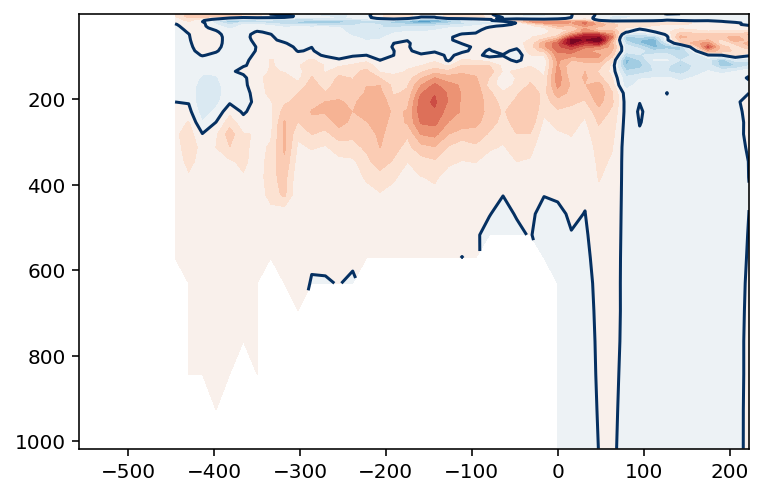

In [17]:
plt.contourf(y_r,clim.st_ocean, interpolated_data_EN_ABS, cmap='RdBu_r', levels=np.linspace(-.5,.5,21))
plt.contour(y_r,clim.st_ocean, interpolated_data_EN_ABS, cmap='RdBu_r', levels=[0], c=rotblau[3]); plt.gca().invert_yaxis()

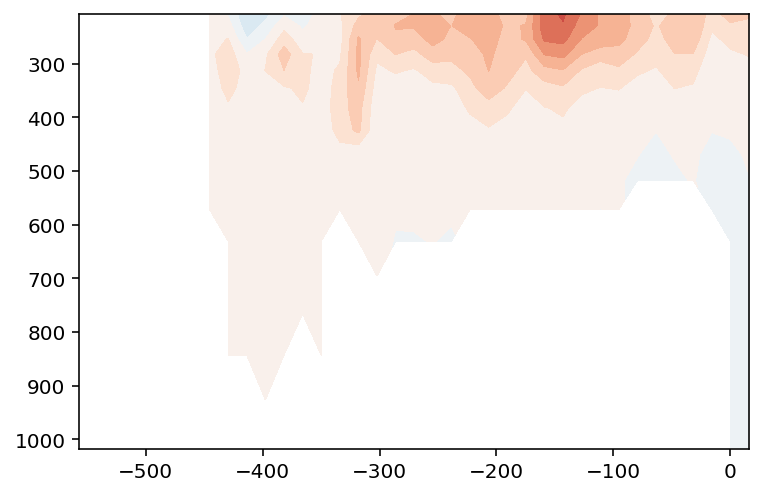

In [18]:
plt.contourf(y_r[0:37],clim.st_ocean[30:47], interpolated_data_EN_ABS[30:47,0:37], cmap='RdBu_r', levels=np.linspace(-.5,.5,21)); plt.gca().invert_yaxis()

In [19]:
np.nanmean(interpolated_data_EN_ABS[30:47,0:37])

0.04975780520876539

CPU times: user 726 ms, sys: 19.4 ms, total: 746 ms
Wall time: 759 ms


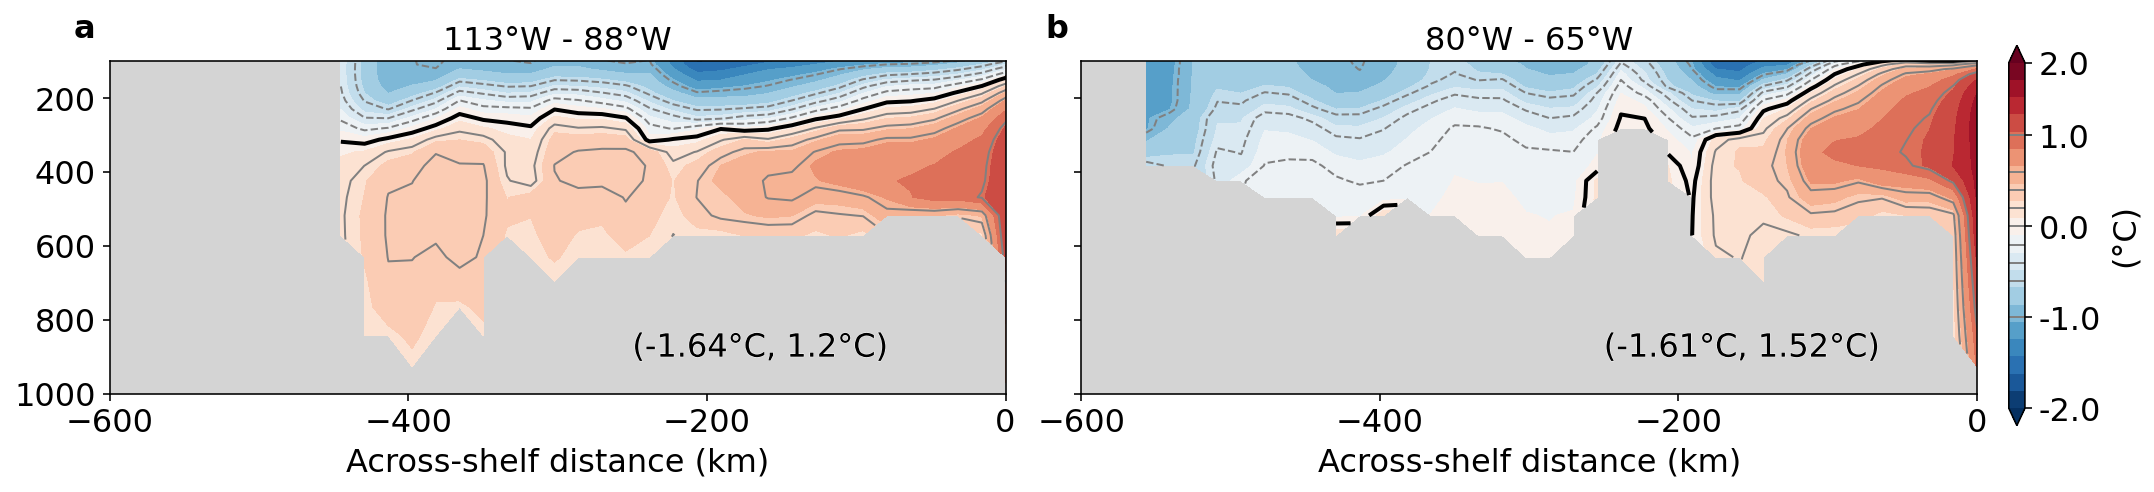

In [20]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(14, 11),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3,4, width_ratios = [1,.3,.3,1], height_ratios = [1,.5,.5]) 

midlon = -105
maxlon = midlon + 65
minlon = midlon - 65
minlat = -80
maxlat = -60
midlat = (minlat + maxlat)/2
ticks = np.linspace(-2,1.8,21)
month = 2 # only select timestep 3 of the dataset = 2045-12-16 12:00:00
for f in [2,3]:#range(6):#range(7): # loop through each subplot
                                                                                        # isotherm positions during the event
    if f == 2:  panel = gs[1,0:2]; titel = '113°W - 88°W'; iso = interpolated_data_clim_ABS; y_r = y_r_ABS; interpolated_mask = interpolated_mask_ABS
    if f == 3:  panel = gs[1,2:4]; titel = '80°W - 65°W'; iso = interpolated_data_clim_WAP; y_r = y_r_WAP; interpolated_mask = interpolated_mask_WAP

    # panels with depth-latitude temperature anomalies -------------------------------------------------------------------------------------------- #
    if f in [2,3]:
        ax1 = plt.subplot(panel)
        
        ax1.set_facecolor([.83, .83, .83])
        
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1 =  plt.contourf(y_r, clim.st_ocean, iso, cmap = 'RdBu_r', levels = ticks, extend='both')
        p11 = plt.contour(y_r, clim.st_ocean, iso, levels=[0], colors = 'grey', linewidths=.25)
        p2 =  plt.contour(y_r, clim.st_ocean, iso, levels=[-1,-.6,-.4,-.2,0,.2,.4,.6,1], linewidths=1, colors='grey')
        p22 = plt.contour(y_r, clim.st_ocean, iso, levels=[0], linewidths=2, colors='k')
        # ----------------------------------------------------------------------------------------------------------------------------------------- #

        plt.gca().invert_yaxis()
        fancy_plot2(ax1, 'Across-shelf temperatures')
        plt.xlabel('Across-shelf distance (km)', fontsize=16)

        if f in [2,3]: 
            plt.locator_params(axis='x', nbins=4) # only 3 y-axis ticks
            # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
            plt.xlabel('Across-shelf distance (km)', fontsize=16)
            
            ax1.text(-.04, 1.07 ,string.ascii_lowercase[f-2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

        # if f in [3,5]: 
        #     plt.xlim([-74,-69]);
        #     labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['330', '220', '110', '0', '110']) # replace labels in °N with across-shelf distance
        fancy_plot2(ax1, titel)
        plt.ylim([1000, 100]); plt.xlim([-600,0])
        

        # hide superfluous tick labels and ticks
        if f in [3,5]: ax1.set_yticklabels([])
        if f == 3:
            # add colour bar        
            cax = fig.add_axes([1, .27, .008, .24]) # position: [x0, y0, width, height]
            from matplotlib.ticker import FuncFormatter
            fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical', format=FuncFormatter(fmt)); 
            cb_txt = cb.set_label(label='(°C)', size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks()
            cb.add_lines(p2) # add contours to colour bar
    
    
    
        # adding minima and maxima temperature to get the range of climatological temperatures on the shelf
        txt = ax1.text(-250, 900, '('+str(np.round(np.nanmin(iso[23:,:36]), 2))+'°C, '+str(np.round(np.nanmax(iso[23:,:36]), 2))+'°C)', fontsize=16, ha='left')
        txt.set_path_effects([PathEffects.withStroke(linewidth=.5, foreground='w')])    
            
            
            
            # 
# --- saving as 300 dpi .PNG image in specified folder ---------------------------------------------- #
plt.savefig(save + 'temp_iso', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                                   #
            format=None, transparent=False, bbox_inches='tight',                                      #
            pad_inches=0.1, metadata=None)                                                            #
# --- end of script --------------------------------------------------------------------------------- # 
# Wall time: 37.1 s

Ok, the total temperature range is (-1.64, 1.52)°C, and $\frac{\Delta\Theta^{max}}{2} = (1.52-1.64)/2 = 3.16/2 = 1.58$

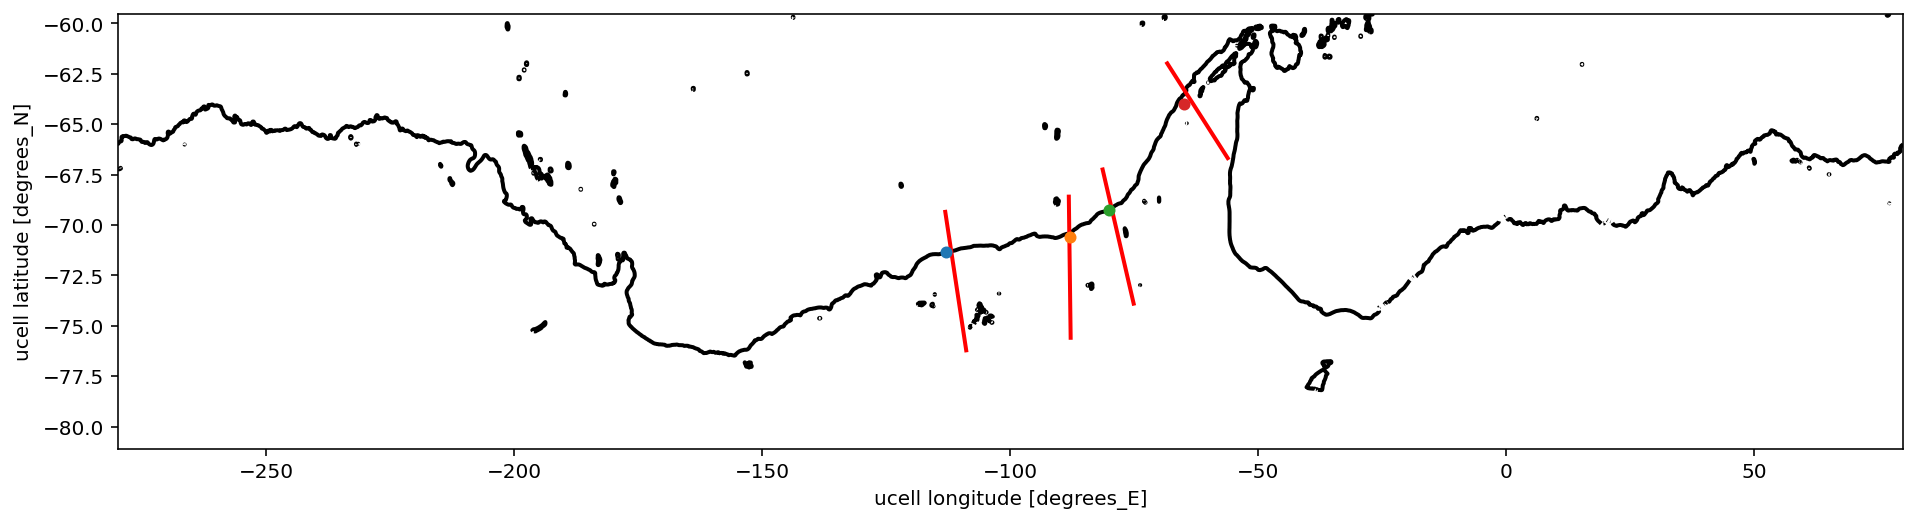

In [21]:
plt.figure(figsize=(16,4))
p111 = (field[0:500,:]).plot.contour(levels = [1000], linewidths=2, cmap='k') # 1000 m isobath

plt.plot([a_ABS[18],c_ABS[18]],[b_ABS[18],d_ABS[18]], color = 'r', linewidth=2) # western line
plt.plot([a_ABS[29],c_ABS[29]],[b_ABS[29],d_ABS[29]], color = 'r', linewidth=2) # eastern line
plt.plot([a_WAP[34],c_WAP[34]],[b_WAP[34],d_WAP[34]], color = 'r', linewidth=2) # western line
plt.plot([a_WAP[41],c_WAP[41]],[b_WAP[41],d_WAP[41]], color = 'r', linewidth=2) # eastern line

plt.plot(-113, b_ABS[18]-2, marker='o', markersize=5); plt.plot(-88, b_ABS[29]-2, marker='o', markersize=5)
plt.plot(-80, b_WAP[34]-2, marker='o', markersize=5);  plt.plot(-65, b_WAP[41]-2, marker='o', markersize=5)

checking if rectangle done correctly

CPU times: user 8.2 s, sys: 334 ms, total: 8.53 s
Wall time: 8.54 s


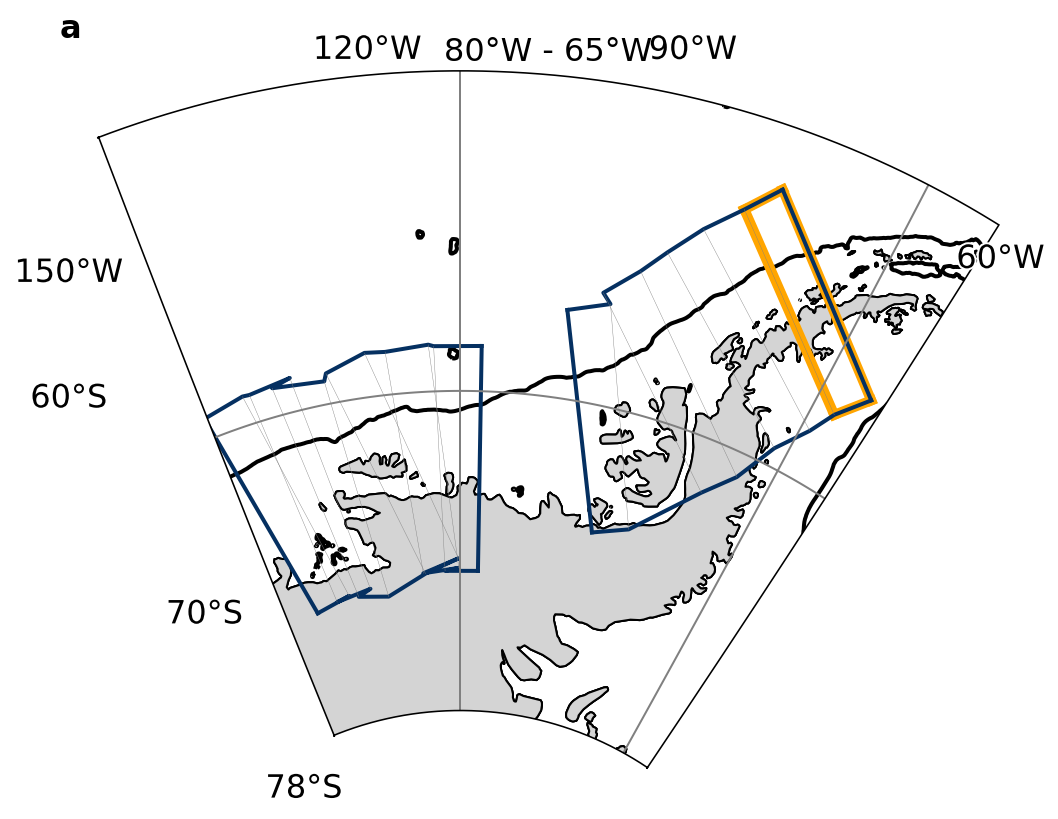

In [22]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(16, 14),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(4,4, width_ratios = [1,1,1,1], height_ratios = [1,.5,.5,.5]) 

midlon = -90
maxlon = midlon + 35
minlon = midlon - 23
minlat = -80
maxlat = -60
midlat = (minlat + maxlat)/2
ticks = np.linspace(-.5,.5,21)
month = 2 # only select timestep 3 of the dataset = 2045-12-16 12:00:00
for f in range(1): # loop through each subplot
    if f == 0:  panel = gs[0,0:2]; map = temp_EN_anom
    # panels with spatial maps -------------------------------------------------------------------------------------------------------------------- #
    if f in [0,1]:
        ax1 = plt.subplot(panel, projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
        ax1.coastlines(resolution='50m')

        lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
        lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

        ax1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

        boundary_path = make_boundary_path(lons, lats)
        ax1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        # p1   = map.plot.pcolormesh(add_colorbar=False, levels=ticks, cmap='RdBu_r', transform=ccrs.PlateCarree())
        # p11  = map.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())
        # 1000 dbar isobath
        p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
                         
        fancy_plot(ax1); # plt.suptitle('Shelf temperatures and surface wind stress', fontsize=16)
        plt.title(titel, fontsize=16)
        ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
                   
            #        [                    x0,                      xe], [                    y0,                      ye]
        plt.plot([np.min(lon_rot_WAP[ 0]), np.min(lon_rot_WAP[-1])], [np.max(lat_rot_WAP[0]), np.max(lat_rot_WAP[-1])], linewidth=5, color = 'orange', transform=ccrs.PlateCarree()) # northern line
        plt.plot([np.max(lon_rot_WAP[ 0]), np.max(lon_rot_WAP[-1])], [np.min(lat_rot_WAP[0]), np.min(lat_rot_WAP[-1])], linewidth=5, color = 'orange', transform=ccrs.PlateCarree()) # southern line
        plt.plot([np.min(lon_rot_WAP[ 0]), np.max(lon_rot_WAP[ 0])], [np.max(lat_rot_WAP[0]), np.min(lat_rot_WAP[ 0])], linewidth=5, color = 'orange', transform=ccrs.PlateCarree()) # western line
        plt.plot([np.min(lon_rot_WAP[-1]), np.max(lon_rot_WAP[-1])], [np.max(lat_rot_WAP[-1]),np.min(lat_rot_WAP[-1])], linewidth=5, color = 'orange', transform=ccrs.PlateCarree()) # eastern line
        
        
        
        # plot the rectangles
        plt.plot(a_ABS,b_ABS, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # northern line Amundsen-Bellingshausen Sea
        plt.plot(c_ABS,d_ABS, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # southern line
        plt.plot(a_WAP,b_WAP, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # northern line West Antarctic Peninsula
        plt.plot(c_WAP,d_WAP, color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # southern line 
        
        # add light grey lines
        for sl in range(len(a_ABS)): plt.plot([a_ABS[sl],c_ABS[sl]],[b_ABS[sl],d_ABS[sl]], color = 'grey', linewidth=.2, transform=ccrs.PlateCarree())
        for sl in range(len(a_WAP)): plt.plot([a_WAP[sl],c_WAP[sl]],[b_WAP[sl],d_WAP[sl]], color = 'grey', linewidth=.2, transform=ccrs.PlateCarree())

        plt.plot([a_ABS[18],c_ABS[18]],[b_ABS[18],d_ABS[18]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # western line
        plt.plot([a_ABS[29],c_ABS[29]],[b_ABS[29],d_ABS[29]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # eastern line
        plt.plot([a_WAP[34],c_WAP[34]],[b_WAP[34],d_WAP[34]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # western line
        plt.plot([a_WAP[41],c_WAP[41]],[b_WAP[41],d_WAP[41]], color = rotblau[20], linewidth=2, transform=ccrs.PlateCarree()) # eastern line

Caption notes:
- showing a single month, i.e., month 12/24 of the simulation
- (a, b): 100 - 1000 m mean temperature on the shelf masked with the 1000 m isobath
- (c, d): West Antarctic temperature anomalies in the upper 1000 m
- (g, h): rolling mean of 15 grid cells for Ekman velocities

You can see a wider selection of cartopy projections here: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html